In [1]:
from collections import defaultdict
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.metrics import auc
import sys
    
def interpolate(x, y, x_t):
    y_rev = list(reversed(list(y)))
    x_rev = list(reversed(list(x)))
    return np.interp(x_t, x_rev, y_rev)

def average_same_x(x, y_list):
    n = len(x)
    d = len(y_list)
    out = []
    for i in range(n):
        v = 0.0
        for j in range(d):
            v += y_list[j][i]
        v /= d
        out.append(v)
    return out

In [2]:
modes = {'initial-tune': 'Baseline', 'spire': 'SPIRE', 'fs': 'FS'}
trials = [0,1,2,3,4,5,6,7]

In [3]:
print('MAP')
for mode in modes:

    agg = []
    for trial in trials:

        with open('./2-Models/Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
            results = pickle.load(f)
        
        agg.append(results['MAP'])
        
    print(modes[mode], np.round(np.mean(agg), 3), np.round(np.std(agg), 3))


MAP
Baseline 0.641 0.007
SPIRE 0.635 0.007
FS 0.627 0.009


cell+phone-person


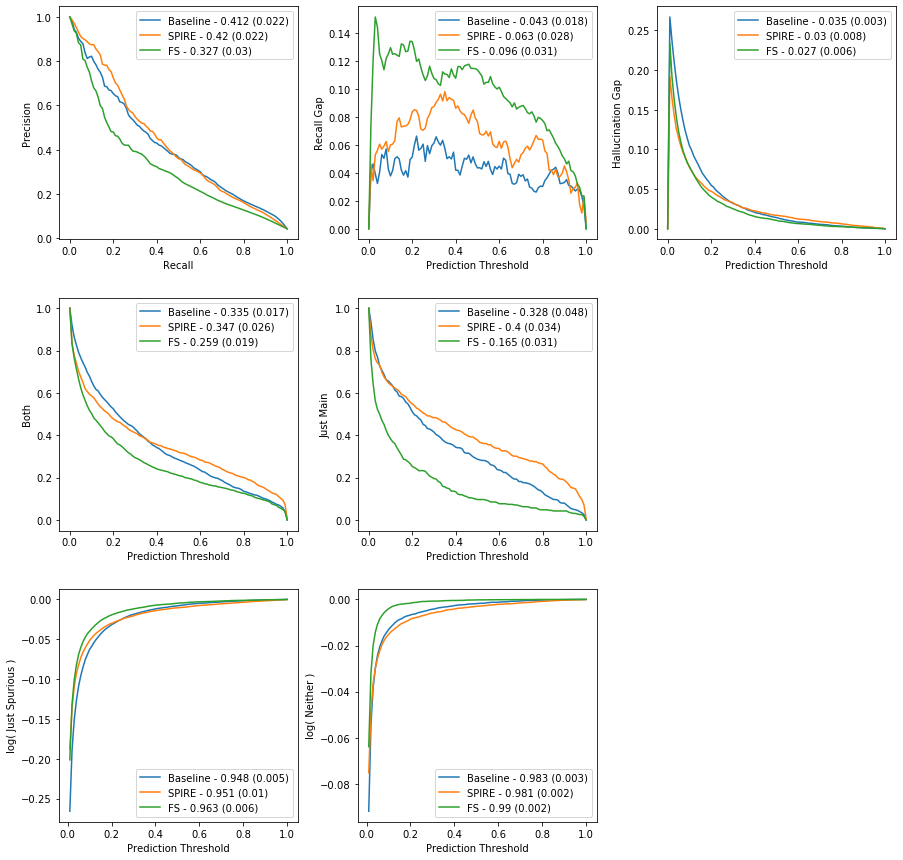

handbag-person


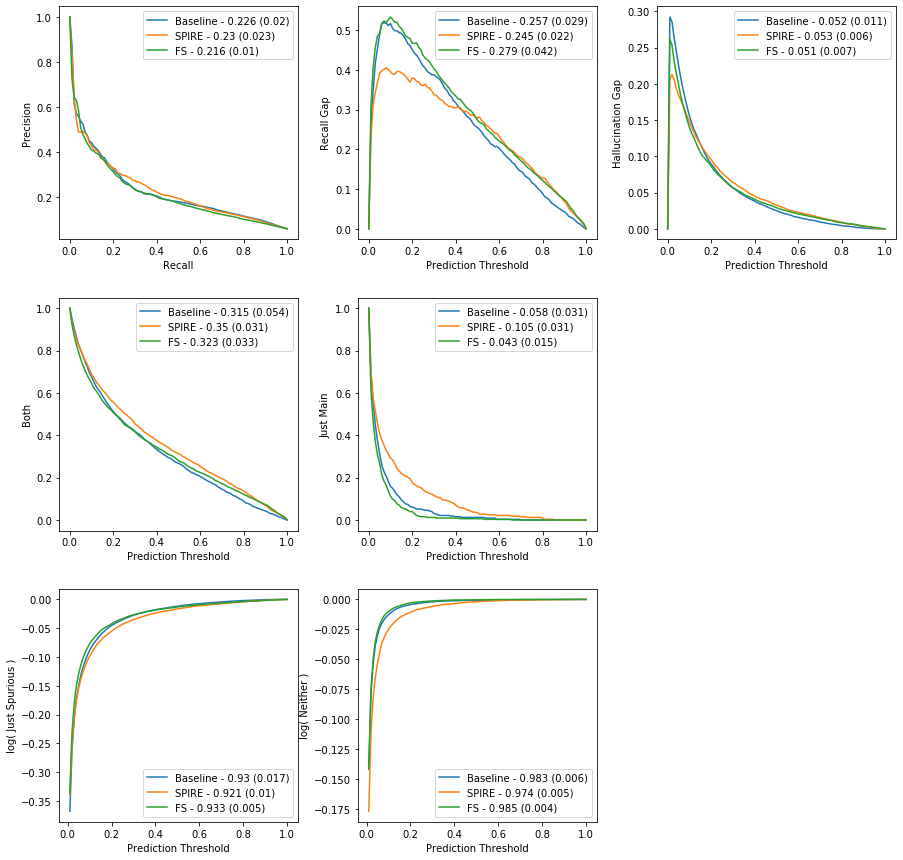

bench-elephant


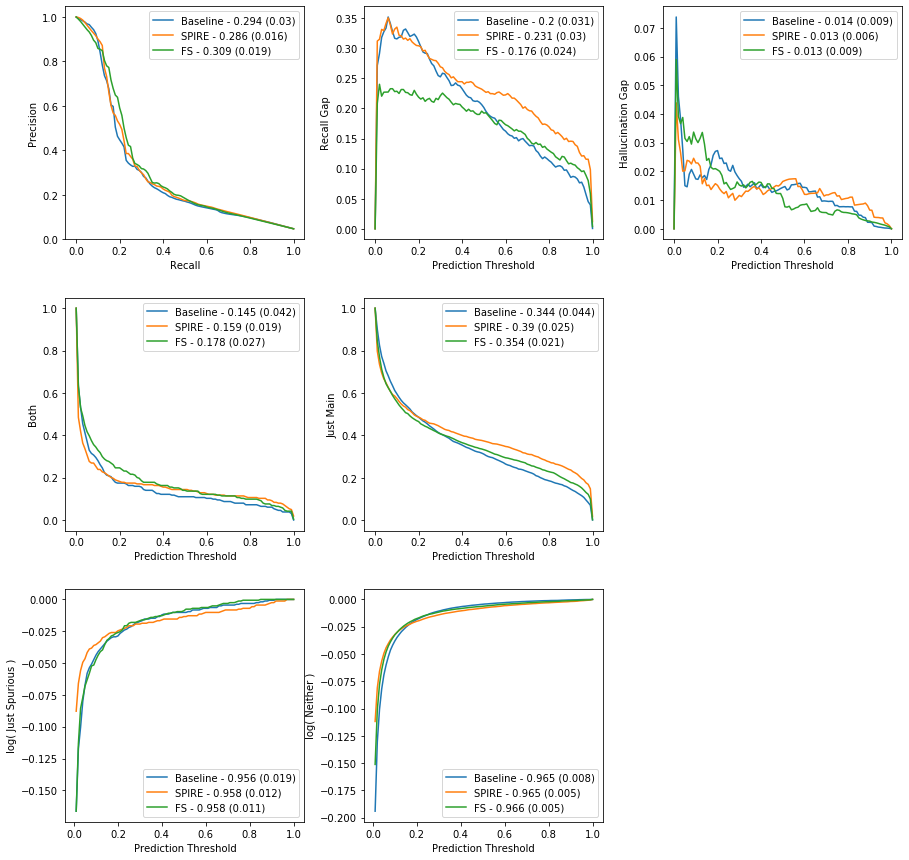

truck-airplane


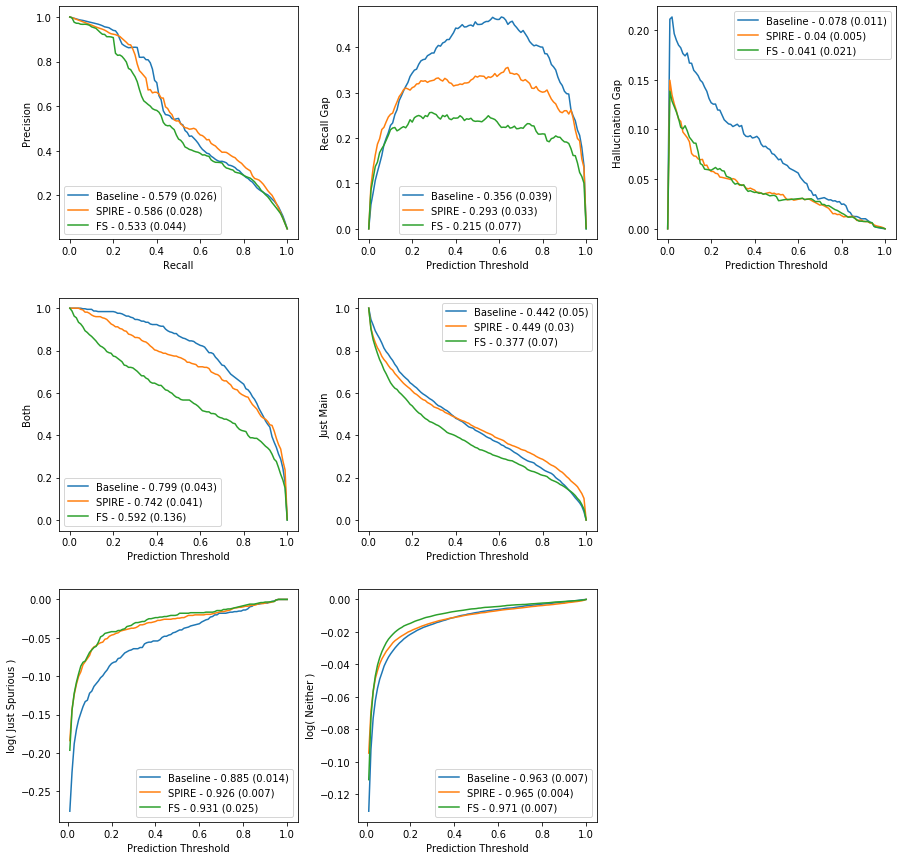

sandwich-dining+table


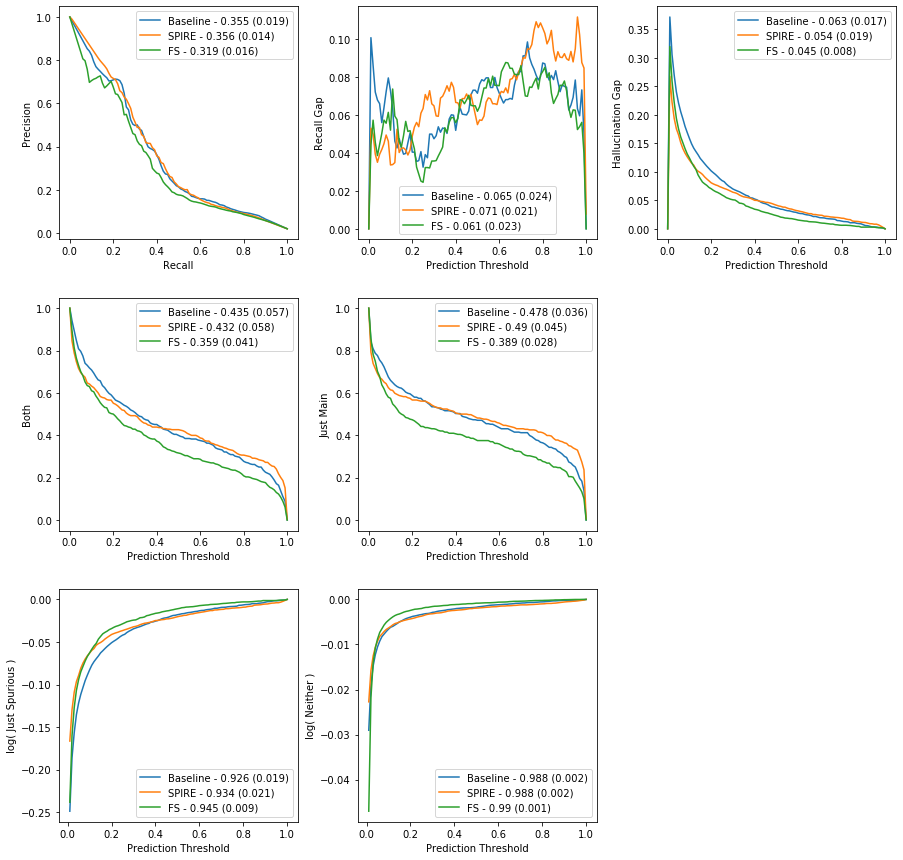

dog-sheep


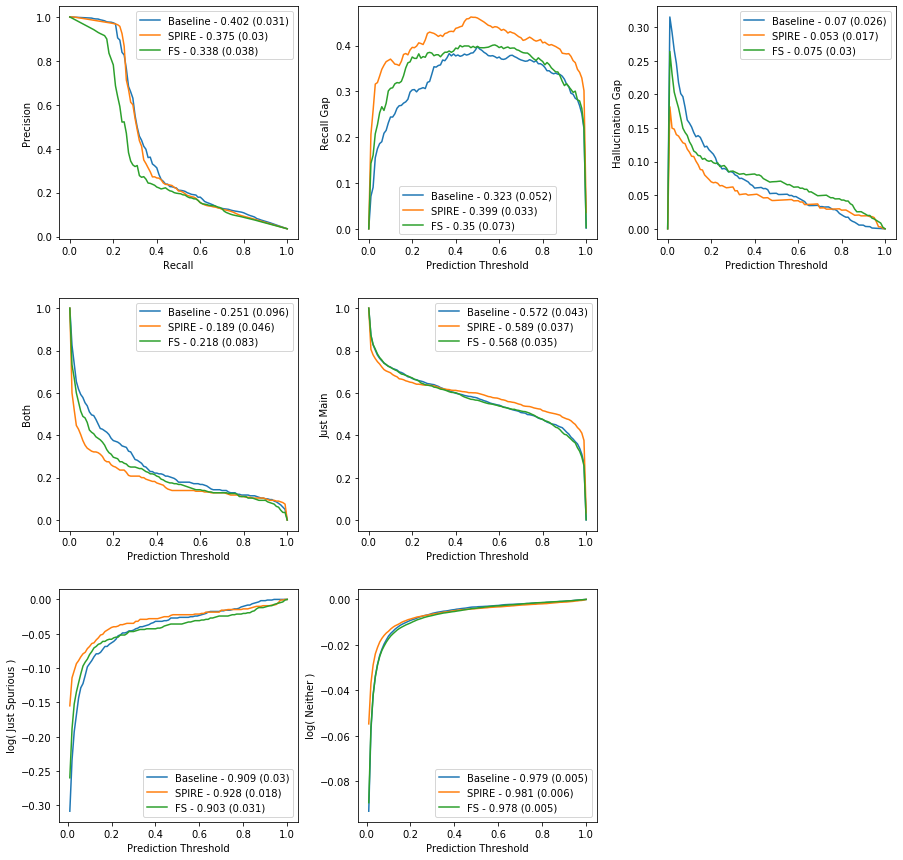

donut-person


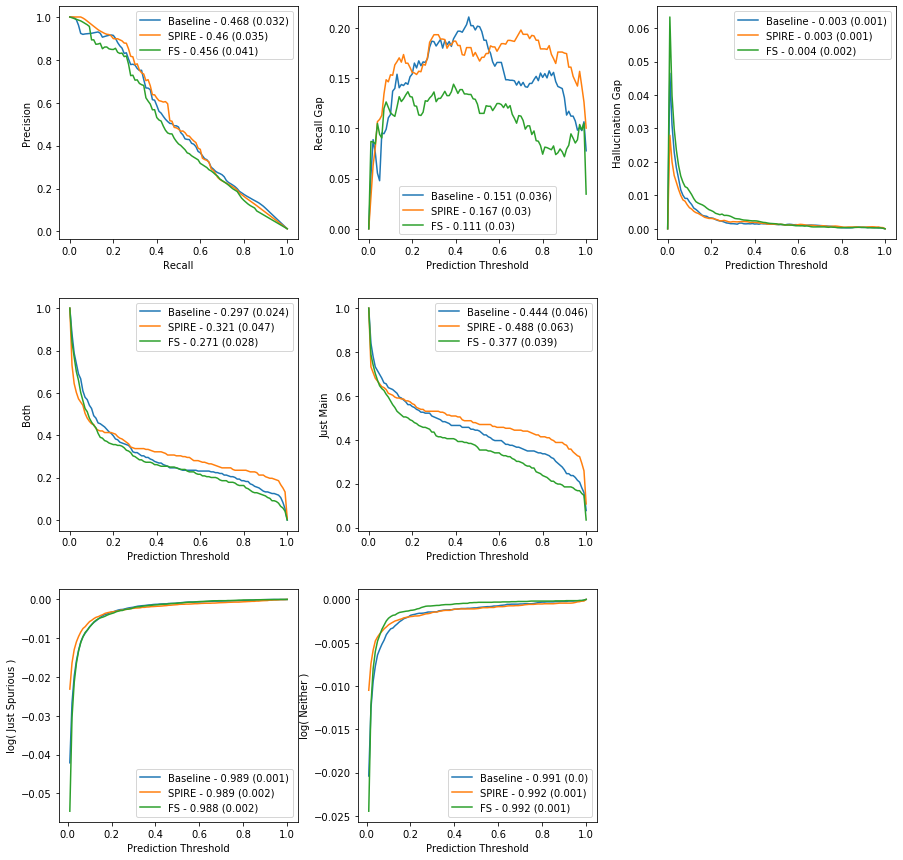

tie-cat


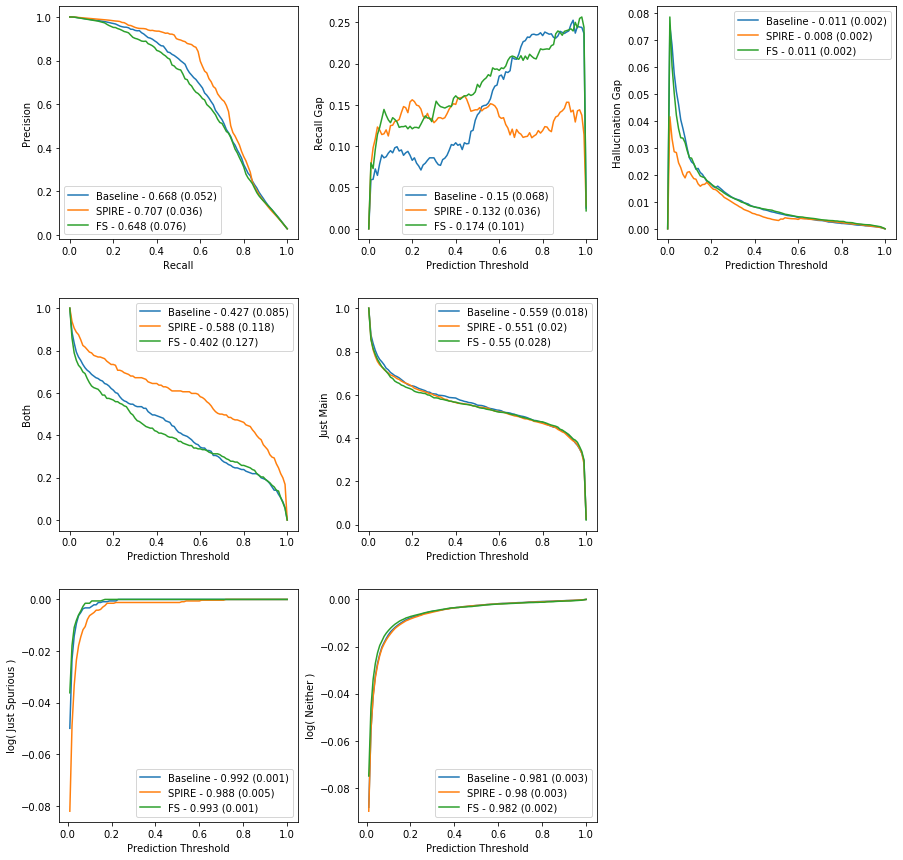

tie-person


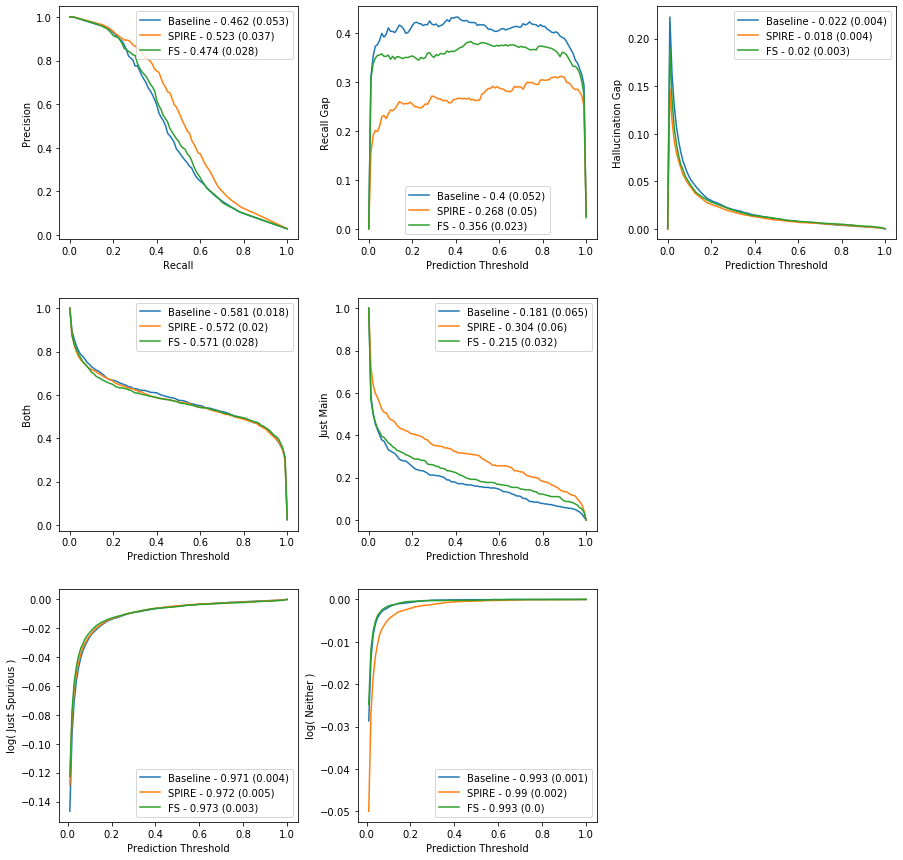

couch-person


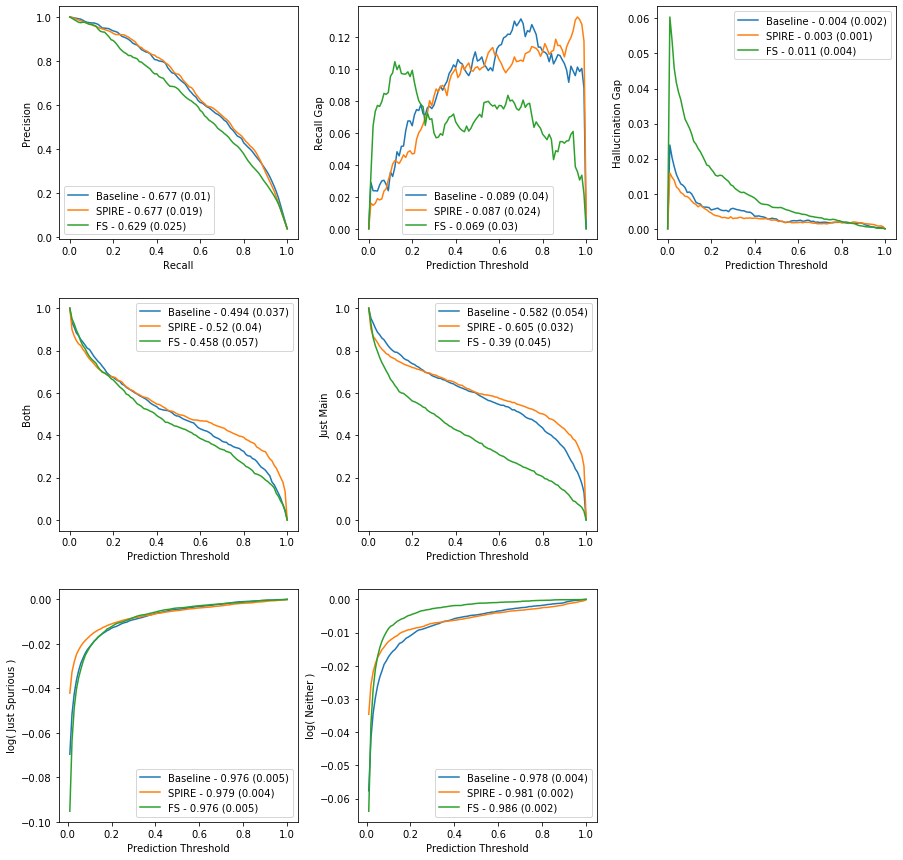

hair+drier-person


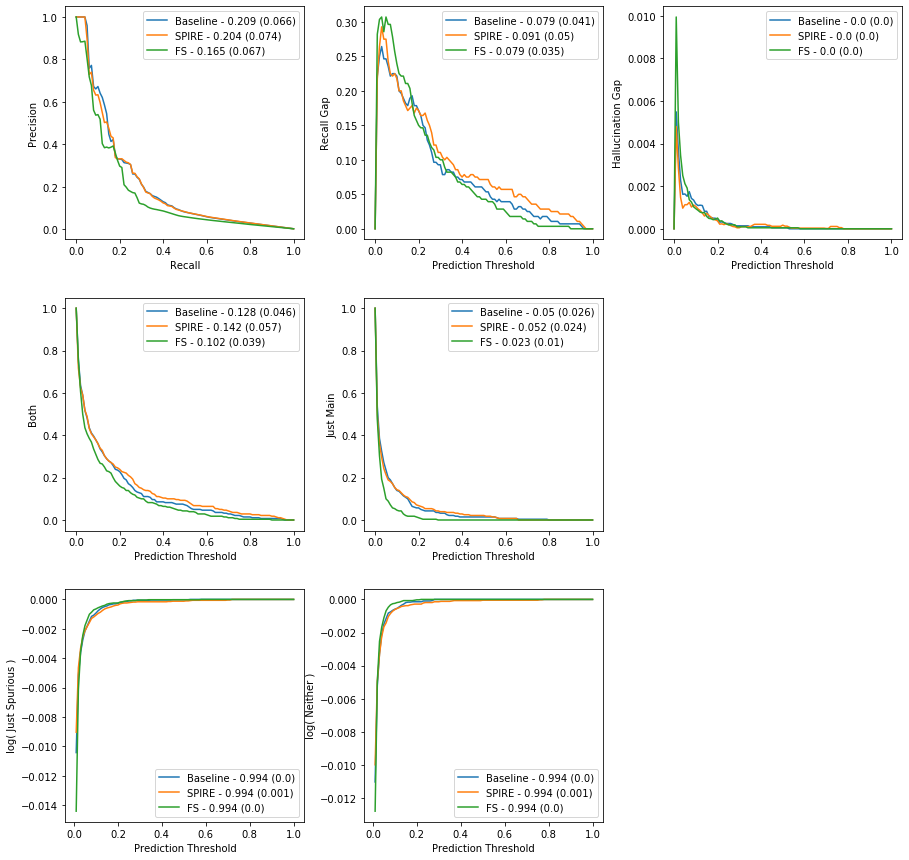

hot+dog-person


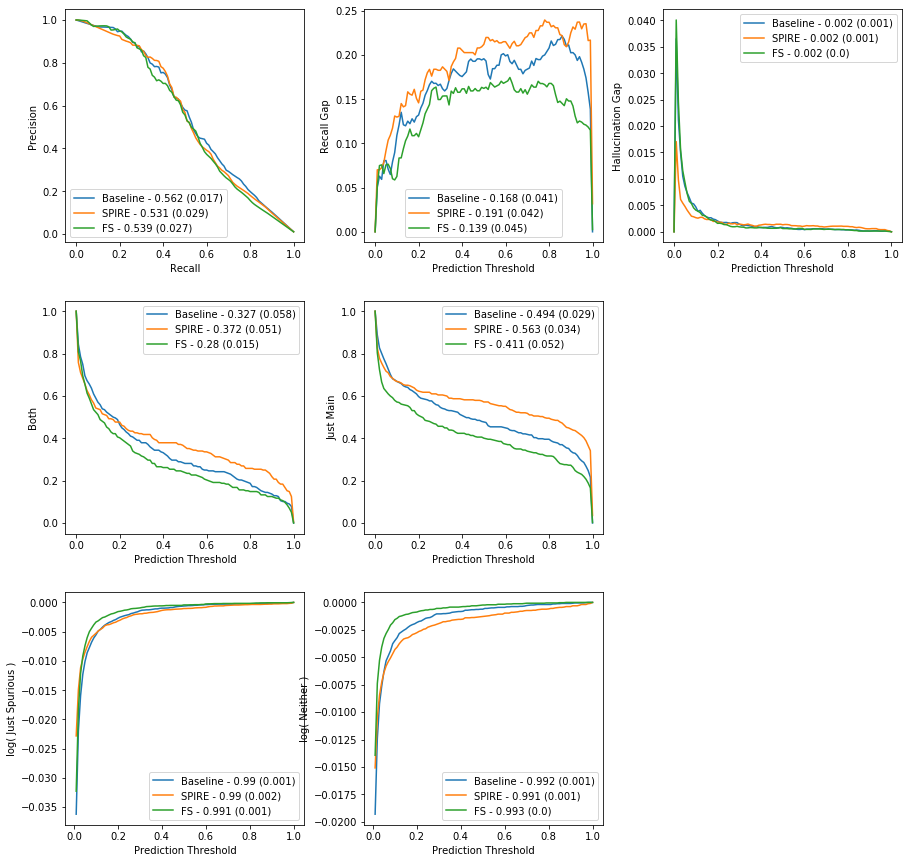

knife-person


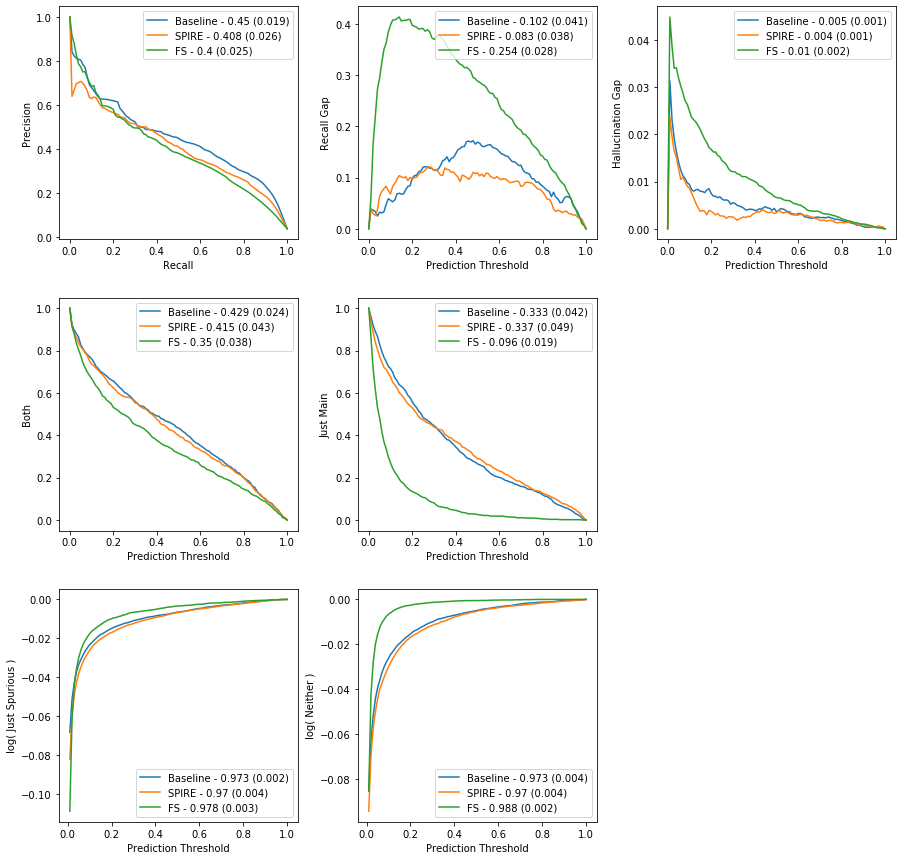

knife-dining+table


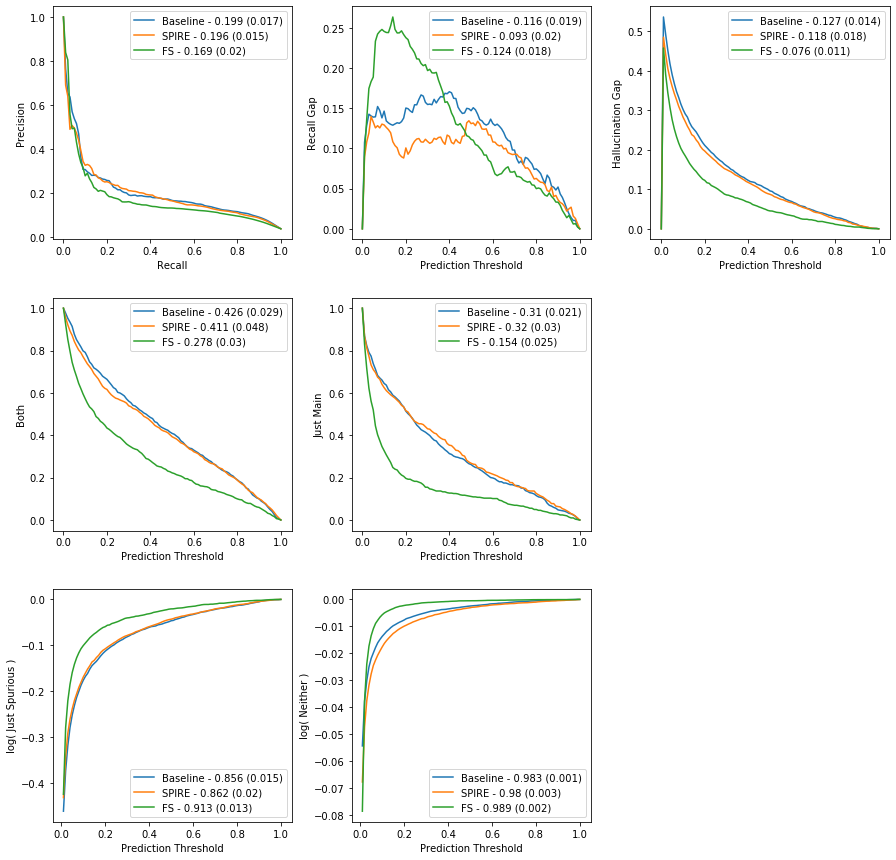

tennis+racket-person


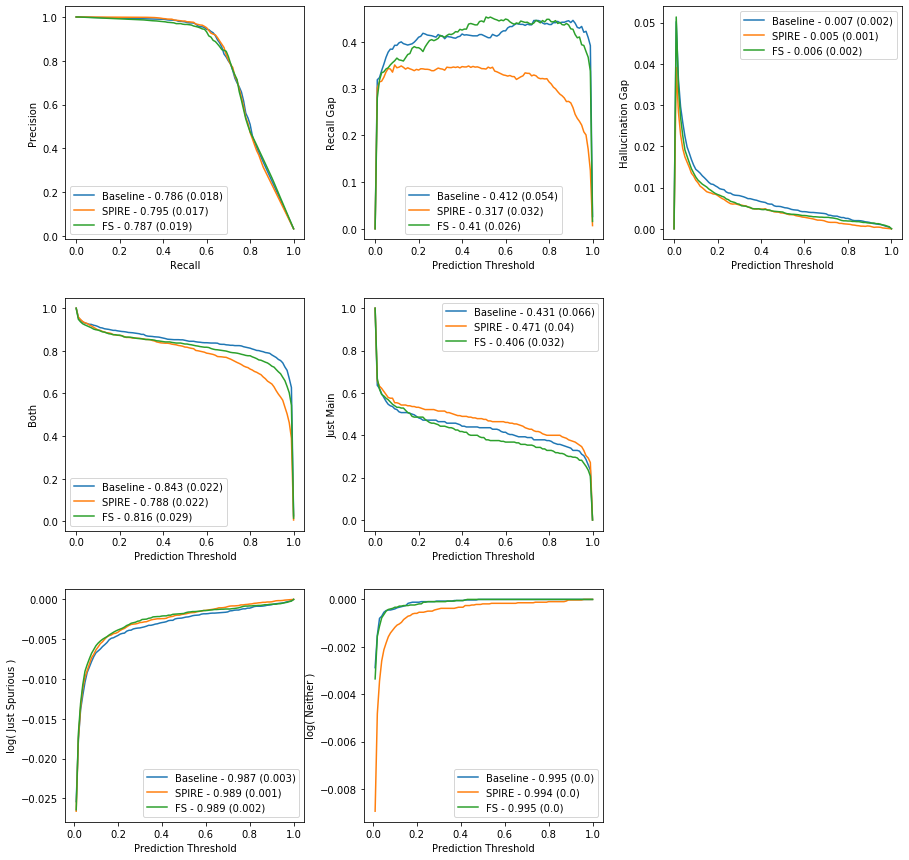

fork-dining+table


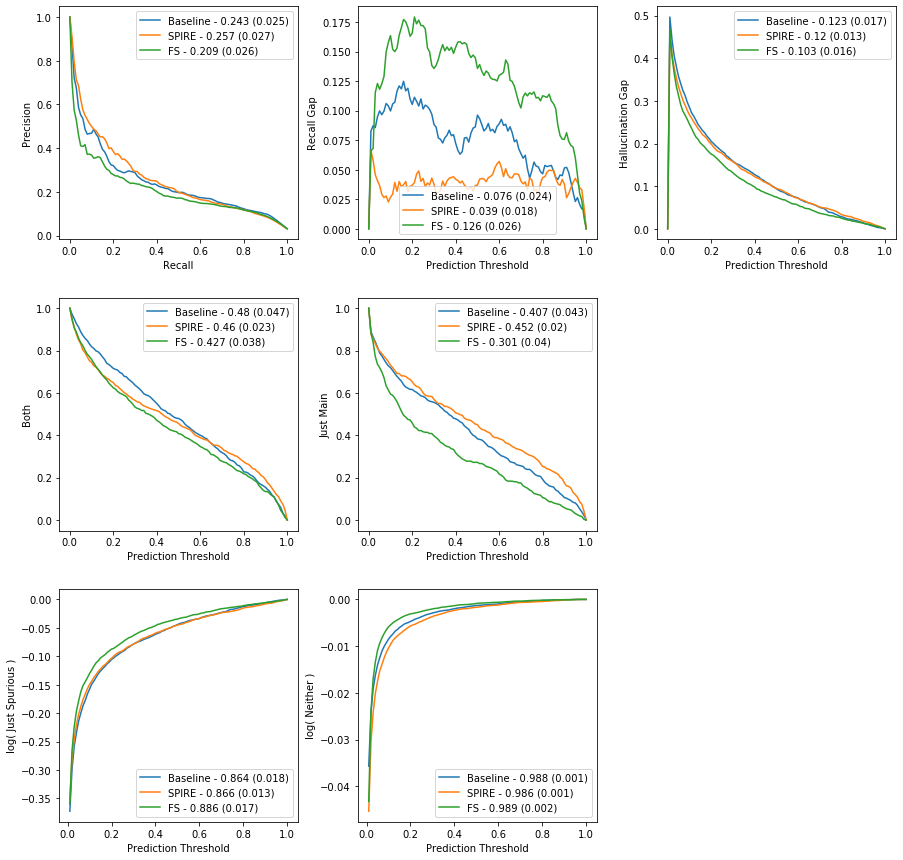

frisbee-person


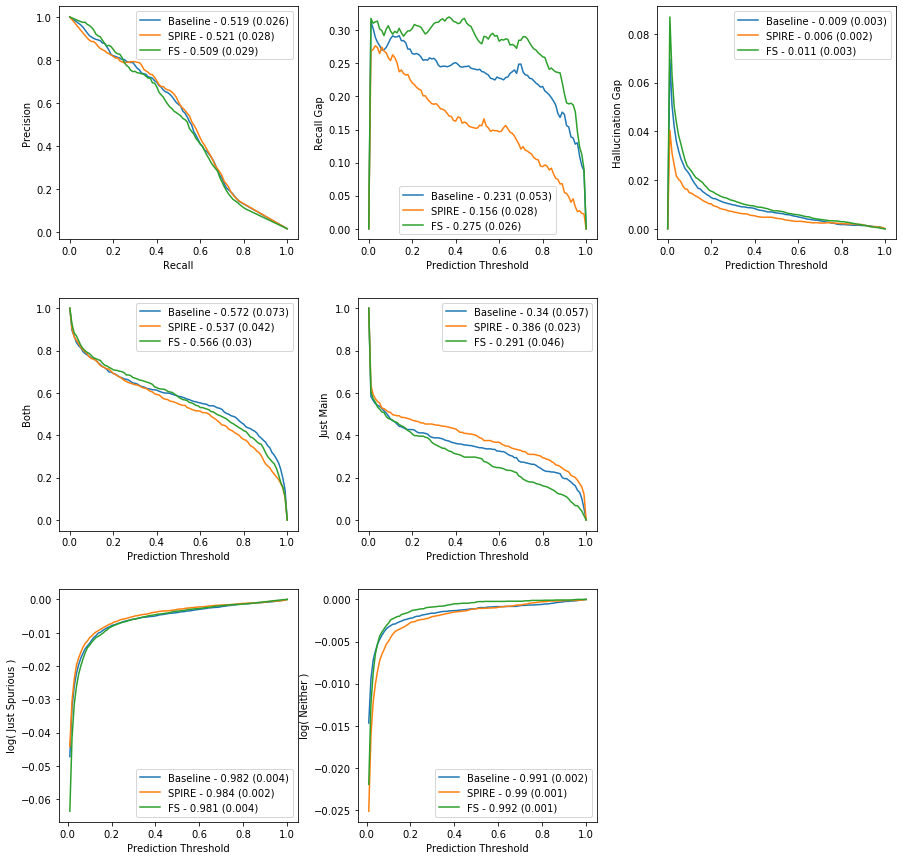

frisbee-dog


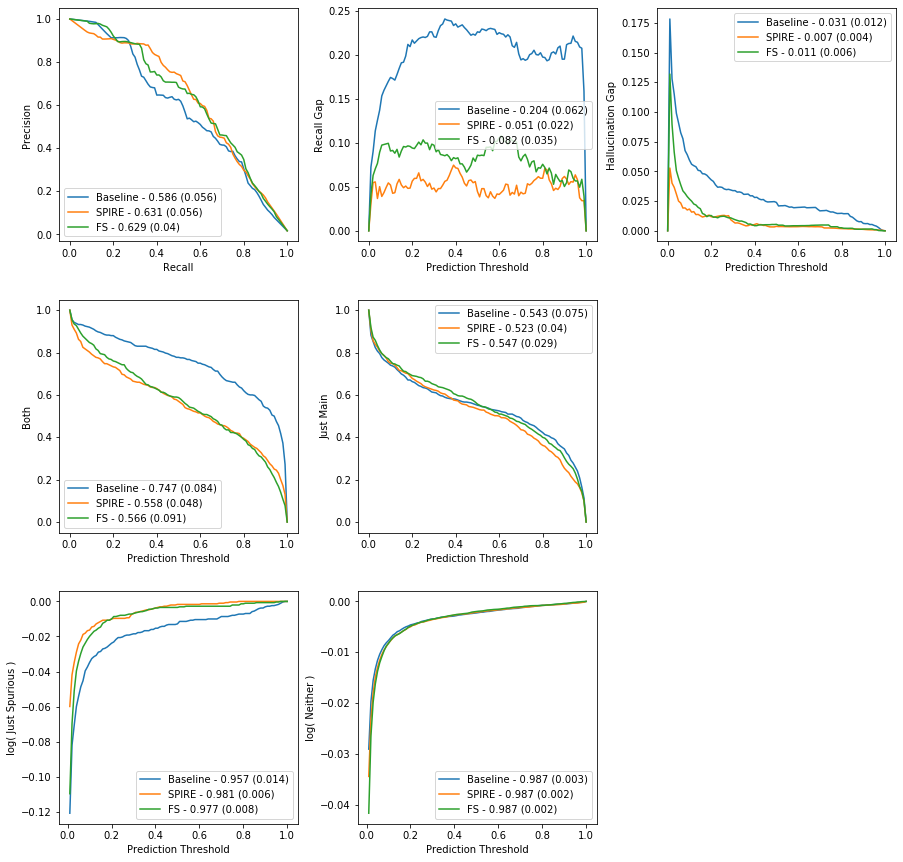

spoon-dining+table


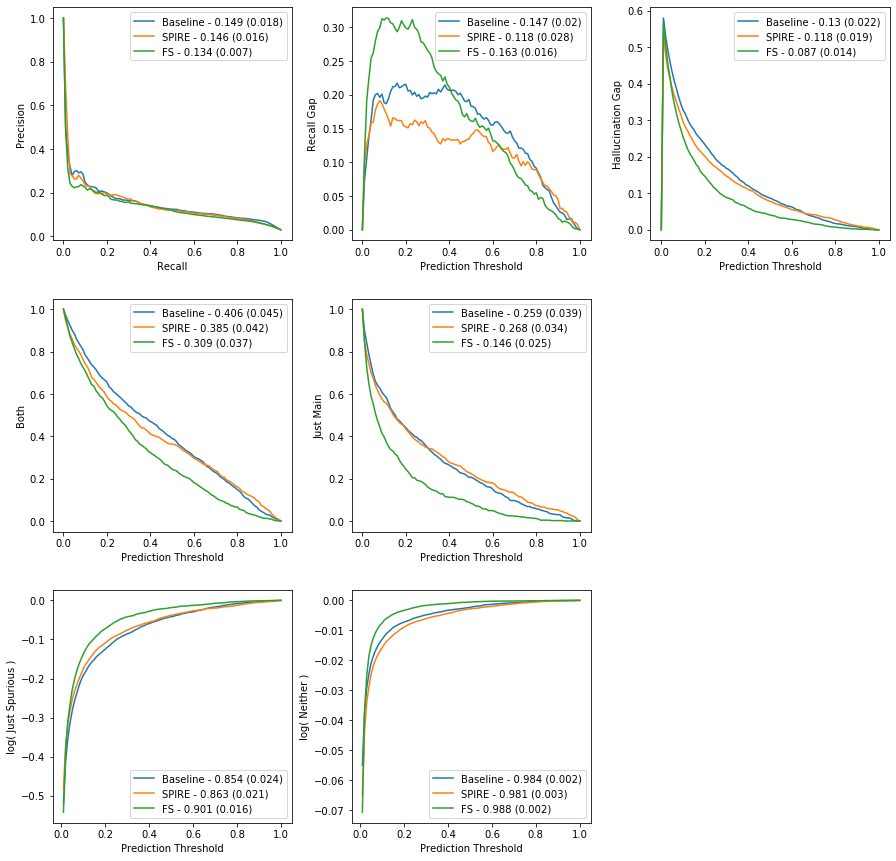

skateboard-person


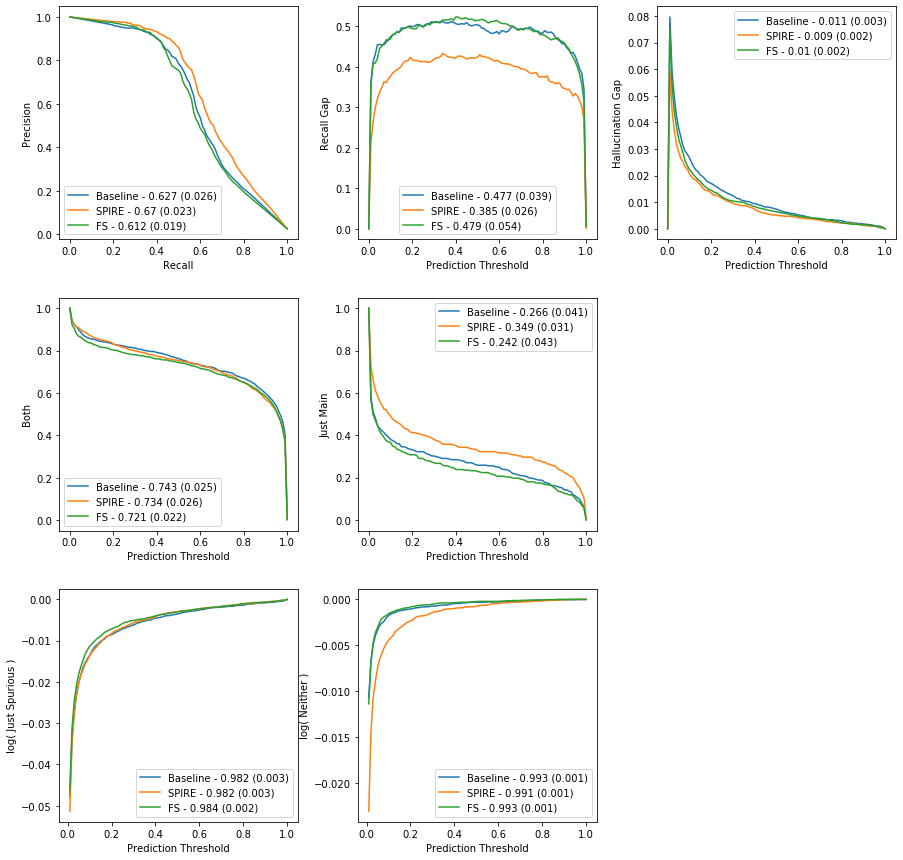

baseball+glove-person


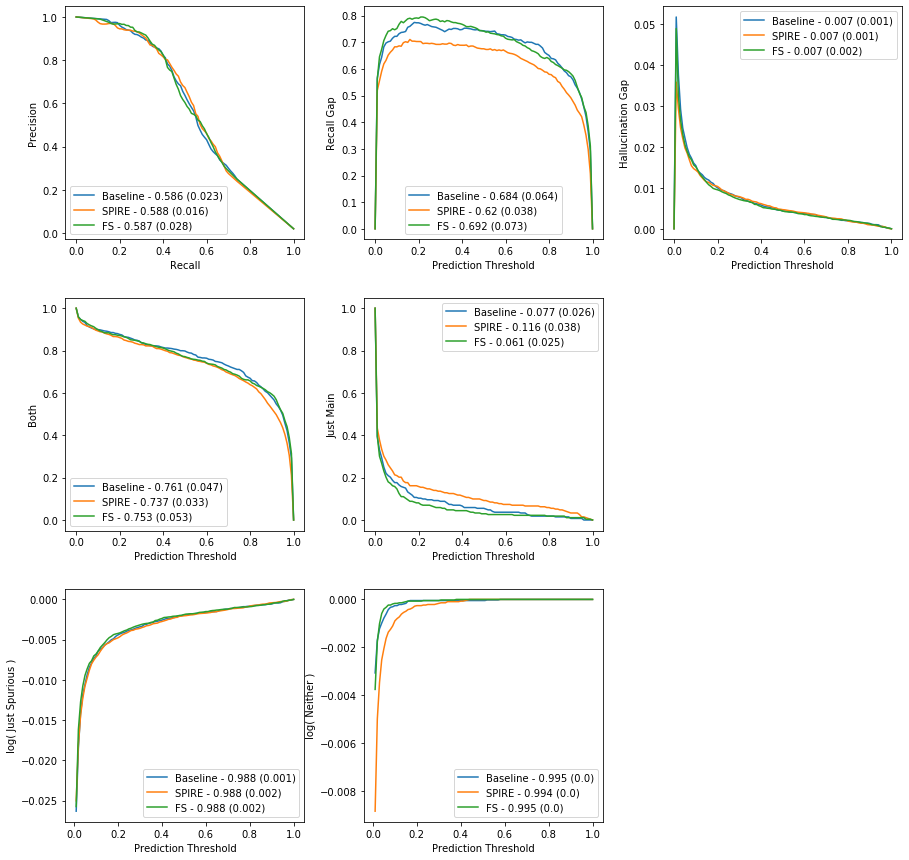

baseball+bat-person


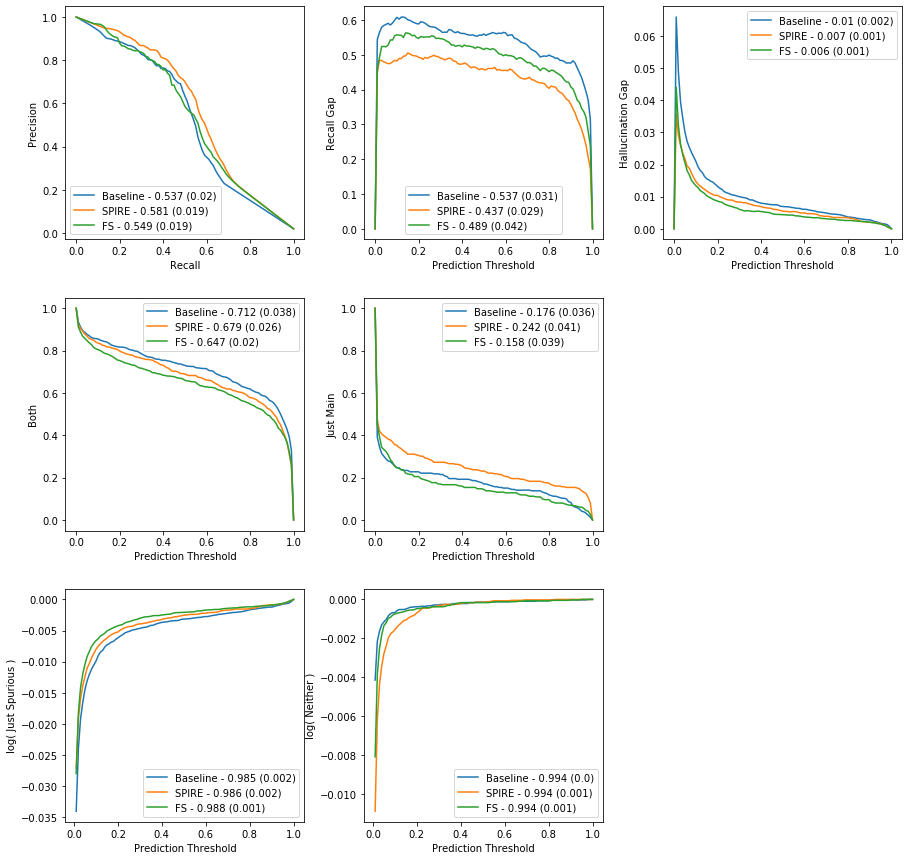

bird-sheep


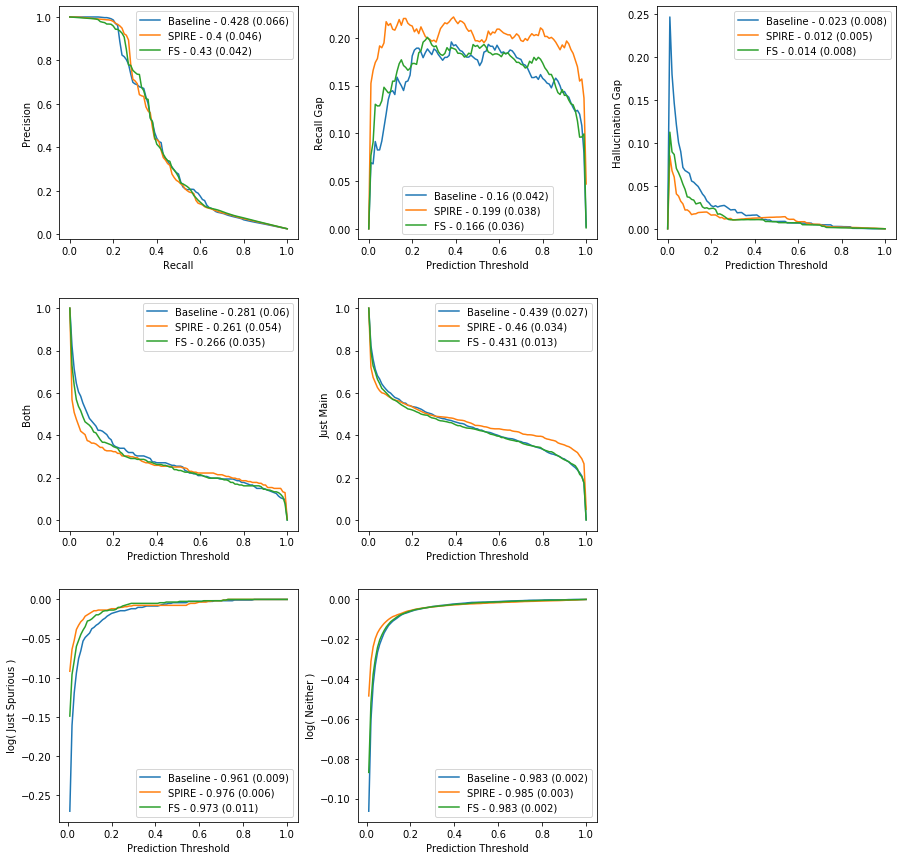

snowboard-person


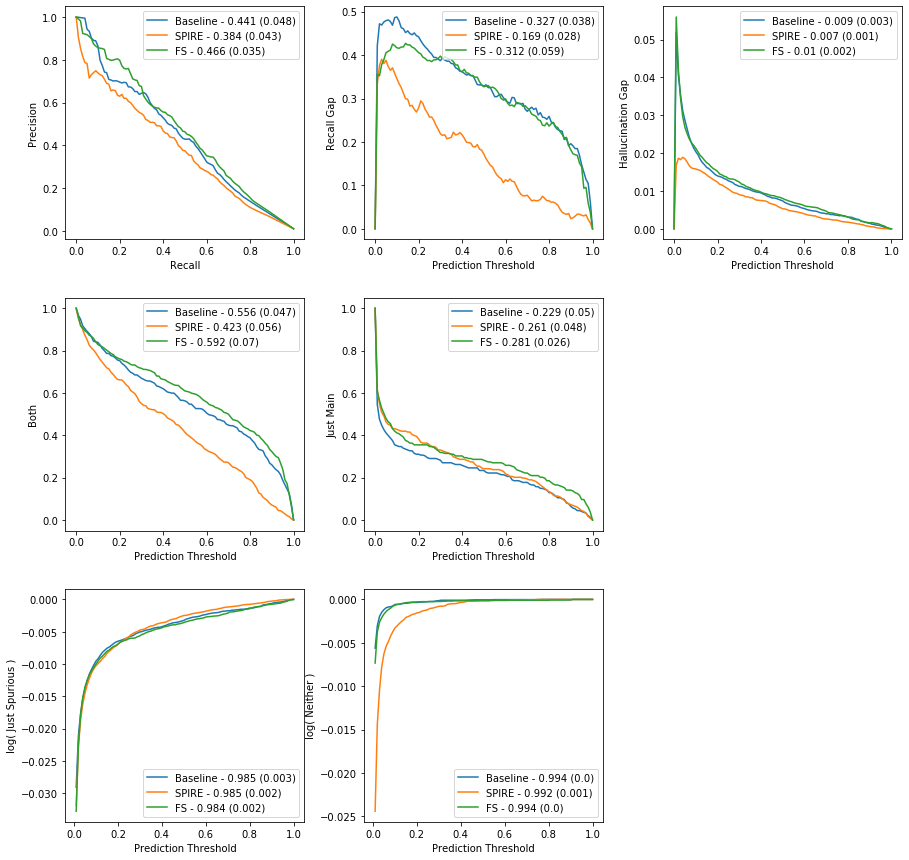

bowl-dining+table


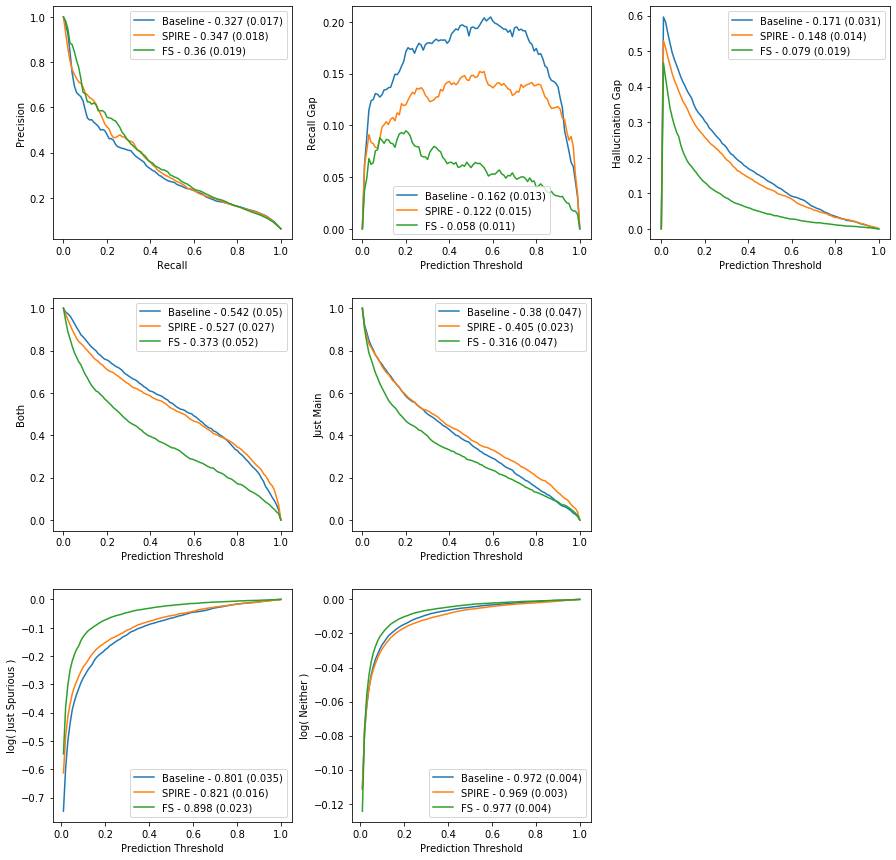

remote-person


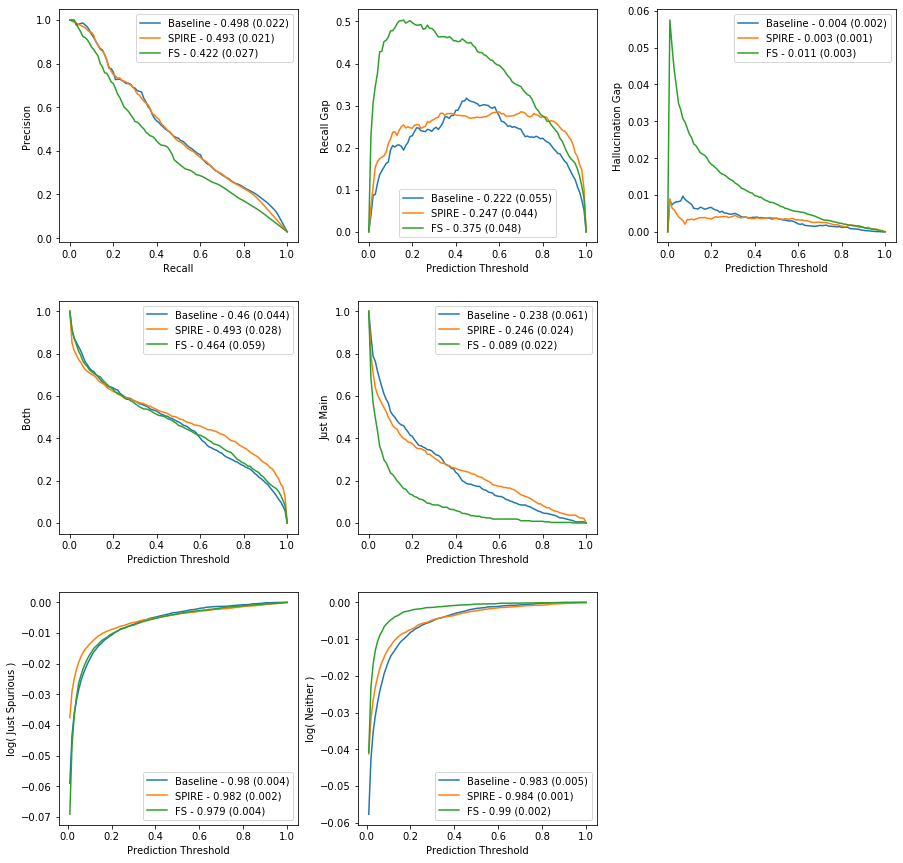

sports+ball-person


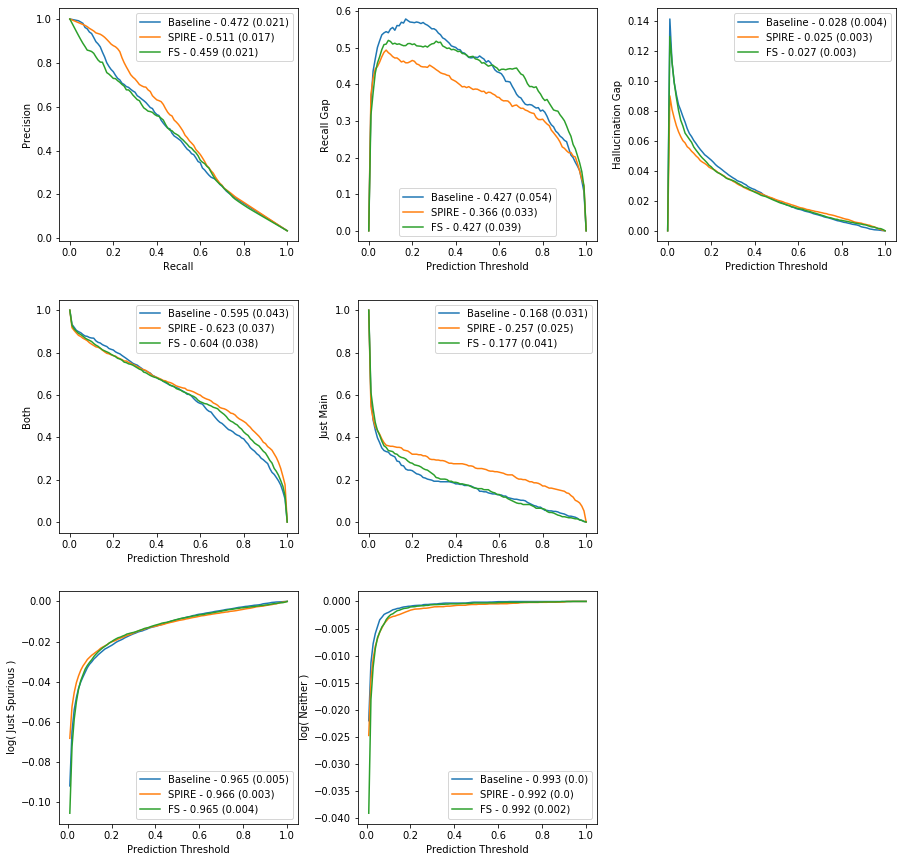

skis-person


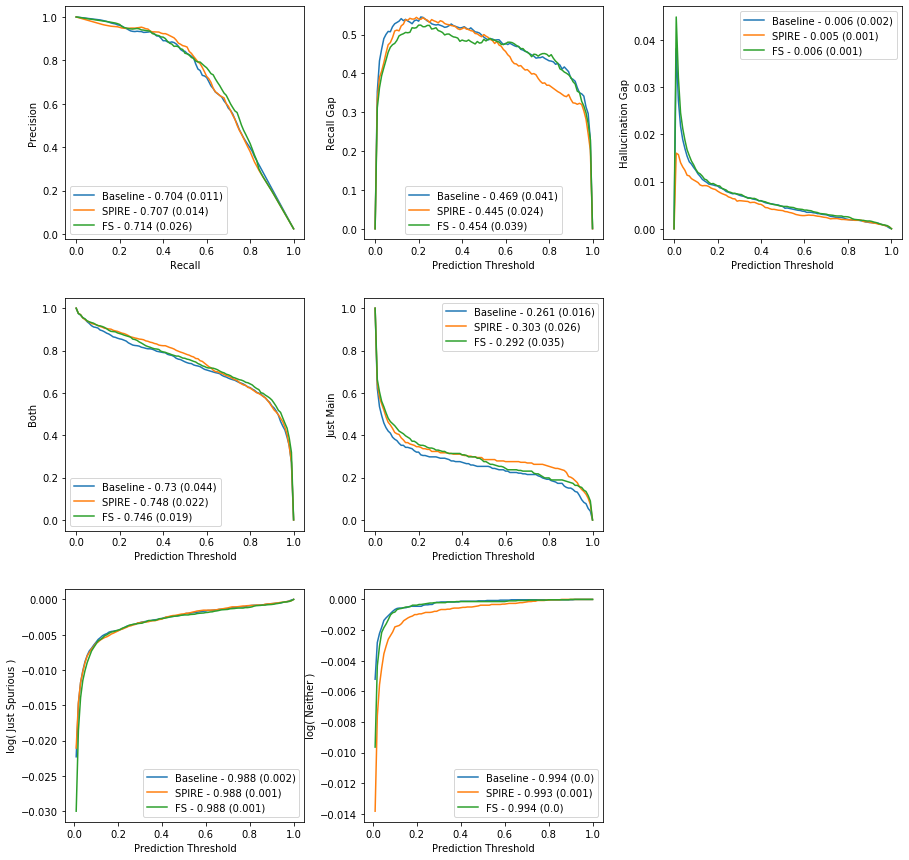

toothbrush-person


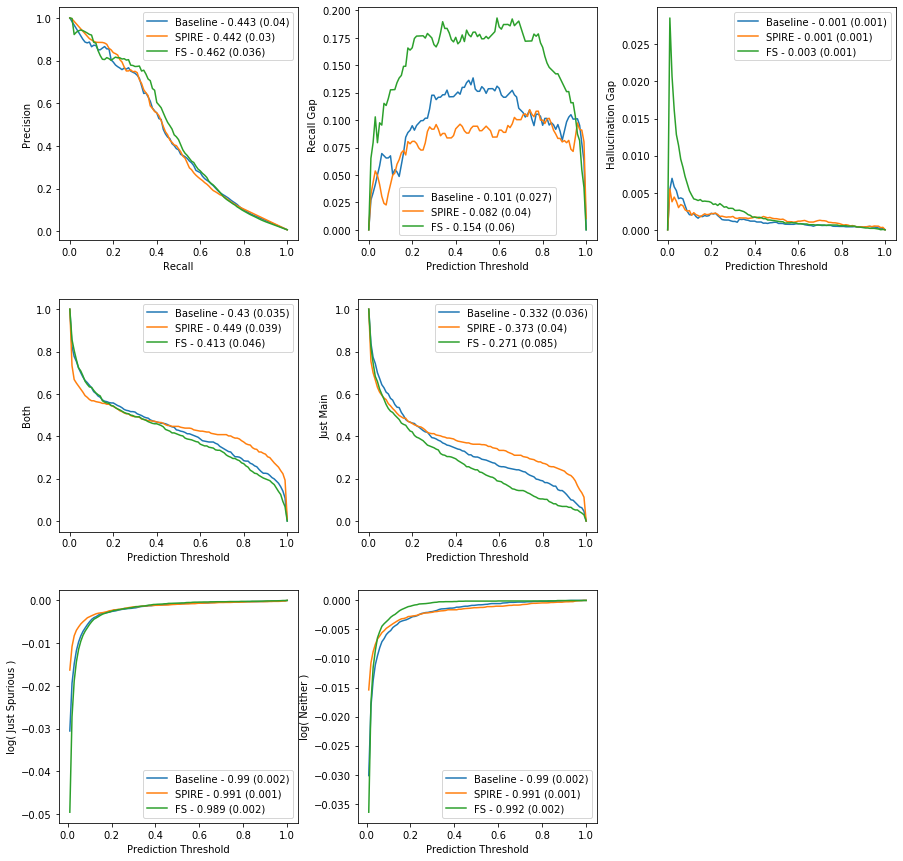

In [4]:
show_accs = True
np.seterr(divide = 'ignore') 

ts = np.linspace(0, 1, num = 101)

with open('./0-FindPairs/Pairs.json', 'r') as f:
    pairs = json.load(f)

data = {}
for mode in modes:
    data[mode] = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 

for pair in pairs:
    print(pair)

    if show_accs:
        fig, ax_all = plt.subplots(3, 3)
        fig.set_figheight(15)
        fig.set_figwidth(15)        
    else:
        fig, ax_all = plt.subplots(1, 3)
        fig.set_figheight(5)
        fig.set_figwidth(15)
    fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
    
    for mode in modes:

        values = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
        curves = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
        for trial in trials:

            with open('./2-Models/Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
                results = pickle.load(f)[pair]
            
            values['ap'].append(results['AP'])
            values['r-gap'].append(results['r-avg'])
            values['h-gap'].append(results['h-avg'])
            
            curves['ap'].append(interpolate(results['recall'], results['precision'], ts))
            curves['r-gap'].append(results['r-gap'])
            curves['h-gap'].append(results['h-gap'])
            for name in ['both', 'just_main', 'just_spurious', 'neither']:
                curves[name].append(results[name])
                values[name].append(auc(ts, results[name]))

        values_avg = {}
        values_std = {}
        curves_avg = {}
        for name in values:
            values_avg[name] = np.round(np.mean(values[name]), 3)
            data[mode][name].append(np.mean(values[name]))
            values_std[name] = np.round(np.std(values[name]), 3)
            curves_avg[name] = average_same_x(ts, curves[name])
            
        
        if show_accs:
            ax = ax_all[0,0]
        else:
            ax = ax_all[0]
        ax.plot(ts, curves_avg['ap'], label = '{} - {} ({})'.format(modes[mode], values_avg['ap'], values_std['ap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        
        if show_accs:
            ax = ax_all[0,1]
        else:
            ax = ax_all[1]
        ax.plot(ts, curves_avg['r-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['r-gap'], values_std['r-gap']))
        ax.set_xlabel('Prediction Threshold')
        ax.set_ylabel('Recall Gap')
        ax.legend()
        
        if show_accs:
            ax = ax_all[0,2]
        else:
            ax = ax_all[2]
        ax.plot(ts, curves_avg['h-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['h-gap'], values_std['h-gap']))
        ax.set_xlabel('Prediction Threshold')
        ax.set_ylabel('Hallucination Gap')
        ax.legend()
        
        if show_accs:
            ax = ax_all[1,0]
            ax.plot(ts, curves_avg['both'], label = '{} - {} ({})'.format(modes[mode], values_avg['both'], values_std['both']))
            ax.set_xlabel('Prediction Threshold')
            ax.set_ylabel('Both')
            ax.legend()

            ax = ax_all[1,1]
            ax.plot(ts, curves_avg['just_main'], label = '{} - {} ({})'.format(modes[mode], values_avg['just_main'], values_std['just_main']))
            ax.set_xlabel('Prediction Threshold')
            ax.set_ylabel('Just Main')
            ax.legend()

            ax = ax_all[2,0]
            ax.plot(ts, np.log10(curves_avg['just_spurious']), label = '{} - {} ({})'.format(modes[mode], values_avg['just_spurious'], values_std['just_spurious']))
            ax.set_xlabel('Prediction Threshold')
            ax.set_ylabel('log( Just Spurious )')
            ax.legend()

            ax = ax_all[2,1]
            ax.plot(ts, np.log10(curves_avg['neither']), label = '{} - {} ({})'.format(modes[mode], values_avg['neither'], values_std['neither']))
            ax.set_xlabel('Prediction Threshold')
            ax.set_ylabel('log( Neither )')
            ax.legend()
            
            ax_all[1,2].set_axis_off()
            ax_all[2,2].set_axis_off()
        
    plt.show()
    plt.close()
    
np.seterr(divide = 'warn');


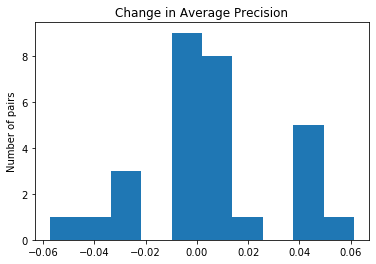

Mean 0.0044
Median 0.0022
Prob > 0 0.5862


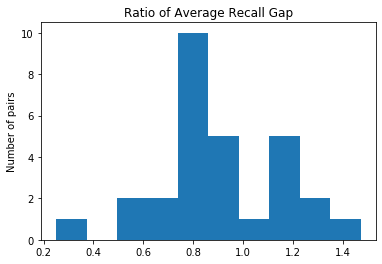

Mean 0.8983
Median 0.8579
Prob < 1 0.6897


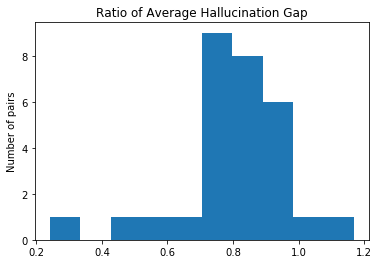

Mean 0.8055
Median 0.8209
Prob < 1 0.931


In [5]:
corrected = 'spire'
#corrected = 'fs'
baseline = 'initial-tune'

for config in  [('ap', 'Average Precision')]:
    v = np.array(data[corrected][config[0]]) - np.array(data[baseline][config[0]])

    plt.hist(v)
    plt.title('Change in {}'.format(config[1]))
    plt.ylabel('Number of pairs')
    plt.show()
    plt.close()
    print('Mean',  np.round(np.mean(v), 4))
    print('Median', np.round(np.median(v), 4))
    print('Prob > 0', np.round(np.mean(v > 0), 4))


for config in [('r-gap', 'Average Recall Gap'), ('h-gap', 'Average Hallucination Gap')]:
    v = np.array(data[corrected][config[0]]) / np.array(data[baseline][config[0]])

    plt.hist(v)
    plt.title('Ratio of {}'.format(config[1]))
    plt.ylabel('Number of pairs')
    plt.show()
    plt.close()
    print('Mean',  np.round(np.mean(v), 4))
    print('Median', np.round(np.median(v), 4))
    print('Prob < 1', np.round(np.mean(v < 1), 4))
 

In [6]:
data_df = []

diffs = np.array(data[corrected]['ap']) - np.array(data[baseline]['ap'])

for i, pair in enumerate(pairs):
    data_df.append([pair, diffs[i]])
    
df = pd.DataFrame(data_df, columns = ['Pair', 'Change in BAP'])

df = df.sort_values('Change in BAP')

print(df.to_string(index = False))

                  Pair  Change in BAP
      snowboard-person      -0.057431
          knife-person      -0.042180
        hot+dog-person      -0.030697
            bird-sheep      -0.027531
             dog-sheep      -0.026518
          donut-person      -0.007984
        bench-elephant      -0.007856
         remote-person      -0.005355
     hair+drier-person      -0.004038
    spoon-dining+table      -0.002997
    knife-dining+table      -0.002573
     toothbrush-person      -0.000786
          couch-person       0.000357
 sandwich-dining+table       0.001424
           skis-person       0.002178
 baseball+glove-person       0.002182
        frisbee-person       0.002791
        handbag-person       0.003572
        truck-airplane       0.006943
     cell+phone-person       0.008758
  tennis+racket-person       0.009219
     fork-dining+table       0.013669
     bowl-dining+table       0.019883
               tie-cat       0.039484
    sports+ball-person       0.039644
     skatebo